#**Import required Dataset and libraries**

In [1]:
import tensorflow as tf
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammadjaberhossain","key":"51a2f504912b24840a4be641d32d9097"}'}

In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
!kaggle datasets download -d mohammadjaberhossain/dataset

 32% 9.00M/28.0M [00:00<00:00, 56.6MB/s]
100% 28.0M/28.0M [00:00<00:00, 133MB/s] 


In [5]:
!7z x dataset.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 29332488 bytes (28 MiB)

Extracting archive: dataset.zip
 64% 4096 Open              --
Path = dataset.zip
Type = zip
Physical Size = 29332488

  0%     17% 1104 - train/Mild_Demented/mild_683.jpg                                             30% 1920 - train/Non_Demented/non_1774.jpg                                            38% 2432 - train/Non_Demented/non_2454.jpg                                            44% 2816 - train

In [6]:
#Importing all the necessary libraries:
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import imagenet_utils
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten, Dropout,Activation

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import os, random
random.seed(10)
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from PIL import Image
from glob import glob
import seaborn as sns

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

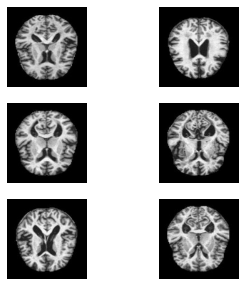

In [7]:
#Displaying some random sample training images: 
image_random_number = 2
path = os.getcwd()+'/'+'train'
dirs = os.listdir(path)

plt.figure(1, figsize=(5, 5))
plt.axis('off')
n = 0
for folder in os.listdir(path):
    list = os.listdir(path+'/'+folder)
    for i in range(image_random_number):
        n += 1
        x = random.randint(1,image_random_number)
        img = list[x]
        img = os.path.join(path,folder,img)
        img = Image.open(img)
        plt.subplot(3, 2, n)
        plt.axis('off')
        plt.imshow(img,cmap='gray')
plt.show()

In [8]:
#resizeing image for BaseNet
IMAGE_SIZE = [224, 224]
IMAGEX= 224;
IMAGEY= 224;
batch_size=16;
train_path = '/content/train'
valid_path = '/content/val'
test_path ='/content/test'

In [9]:
# To get the number of classes in trining data
folders = glob('/content/train/*')

#**AlzheimerNet Model**

In [ ]:
#define the Custom CNN model
model = Sequential()

# Padding = 'same'  results in padding the input such that the output has the same length as the original input
model.add(Conv2D(32, (5, 5), padding='same',input_shape= (IMAGEX, IMAGEY, 3))) #filter size 5x5 and num of filters 32
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3))) #add maxpooling layer of size 2x2 to reduce the feature map size

model.add(Conv2D(64,(5,5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))


model.add(Conv2D(256,(5,5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
#model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3)) #define output layer which has same number of node as number of classes 
model.add(Activation('softmax')) #softmax activation function to generate output
model.summary() #To print the summmary of the model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)        51264     
                                                                 
 activation_1 (Activation)   (None, 74, 74, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                    

In [ ]:
# Defining the callbacks including Early stopping, check points and reduce learning rate as required
checkpoint = ModelCheckpoint("/content/modelPretrain/jaber_cnn_baseNet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True) #early stopping if validation loss does not improve after a certain patience 

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 10,
                              verbose = 1,
                              min_delta = 0.0001) #adjusting the learning rate 

callbacks = [earlystop, checkpoint, reduce_lr] # kepping the call backs into a callback list

In [ ]:
#training , validation and test set generation

train_datagen = ImageDataGenerator(rescale=1./255) #normalizing the images
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGEX, IMAGEY),
        batch_size =16,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        valid_path,
        target_size=(IMAGEX, IMAGEY),
        batch_size=16,
        class_mode='categorical',
        shuffle=False)

test_generator = validation_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGEX, IMAGEY),
        batch_size=16,
        class_mode='categorical',
        shuffle=False)

Found 4480 images belonging to 3 classes.
Found 1280 images belonging to 3 classes.
Found 640 images belonging to 3 classes.


In [ ]:
# tell the model what cost and optimization method to use
#creating the model
model.compile(
  loss='categorical_crossentropy',
  #optimizer=Adam(learning_rate=0.001,  decay=0.01),
  optimizer=Adam(decay=0.01),
  #optimizer='adam',
  metrics=['accuracy']
)

We may now observe loss (loss based on training data) and val loss (loss based on validation data) in addition to our epochs when we begin the training process.When assessing the performance of our model during training, we must always rely on validation data (relying on the training data for estimating model performance is like checking our own homework). That is why, in model.fit, we define a validation split. This may be seen as follows when put together:

In [ ]:
# fit the model
baseNet = model.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=40,
  steps_per_epoch = len(train_generator),
  validation_steps = len(validation_generator),
  callbacks = callbacks
)
model.save('/content/readymodel/baseNet.h5')

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


278/280 [============================>.] - ETA: 0s - loss: 0.9853 - accuracy: 0.5027
Epoch 1: val_loss improved from inf to 0.91524, saving model to /content/modelPretrain/jaber_cnn_baseNet.h5
280/280 [==============================] - 21s 28ms/step - loss: 0.9848 - accuracy: 0.5038 - val_loss: 0.9152 - val_accuracy: 0.5703 - lr: 0.0010
Epoch 2/40
278/280 [============================>.] - ETA: 0s - loss: 0.8929 - accuracy: 0.5492
Epoch 2: val_loss improved from 0.91524 to 0.84616, saving model to /content/modelPretrain/jaber_cnn_baseNet.h5
280/280 [==============================] - 8s 27ms/step - loss: 0.8924 - accuracy: 0.5502 - val_loss: 0.8462 - val_accuracy: 0.5891 - lr: 0.0010
Epoch 3/40
280/280 [==============================] - ETA: 0s - loss: 0.8405 - accuracy: 0.5752
Epoch 3: val_loss improved from 0.84616 to 0.79646, saving model to /content/modelPretrain/jaber_cnn_baseNet.h5
280/280 [==============================] - 8s 30ms/step - loss: 0.8405 - accuracy: 0.5752 - val_loss

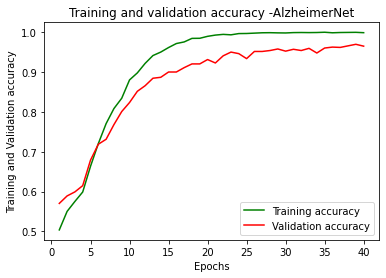

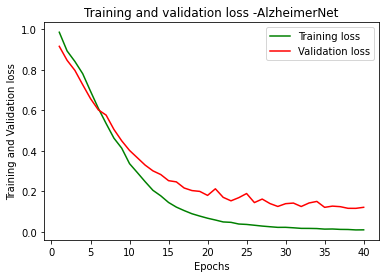

In [ ]:
acc = baseNet.history['accuracy']
epochs = range(1, len(acc)+1)
val_acc = baseNet.history['val_accuracy']
loss = baseNet.history['loss']
val_loss = baseNet.history['val_loss']

#plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy -AlzheimerNet')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation accuracy')
plt.legend()
plt.figure()

#plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss -AlzheimerNet')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
#Finding the accuracy based on test set
BaseNetPrediction = model.predict_generator(test_generator) #making the class predictions on test data
BaseNetPrediction = np.argmax(BaseNetPrediction,axis=1)
accuracyBaseNet = accuracy_score(test_generator.classes,BaseNetPrediction) #Calculating the classification accuracy of the model
print(f'AlzheimerNet model test accuracy is: {(accuracyBaseNet*100):.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


AlzheimerNet model test accuracy is: 96.41%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


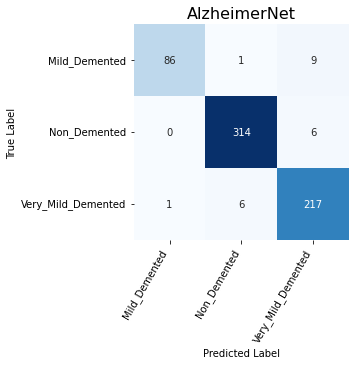

In [ ]:
#creating the confusion matrix using test set
batch_size=16;
test_samples=1200;
class_Names = test_generator.class_indices
Y_pred_baseNet = model.predict_generator(test_generator, test_samples // batch_size+1)
y_pred_baseNet = np.argmax(Y_pred_baseNet, axis=1)
class_Names = {v: k for k, v in class_Names.items()}
# collecting the class names
class_names_CNN = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented']

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap( cm,annot=True, square=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
tClasses = test_generator.classes;
plot_heatmap(tClasses, y_pred_baseNet, class_names_CNN, ax1, title="AlzheimerNet")    
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
#Creating classification result based on test set
class_labels = test_generator.class_indices
class_labels_baseNet = {v: k for k, v in class_labels.items()}
target_names = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented']
print('\n Classification report: Pretrained BaseNet \n')
print(classification_report(test_generator.classes, y_pred_baseNet, target_names=target_names))


 Classification report: Pretrained BaseNet 

                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.90      0.94        96
      Non_Demented       0.98      0.98      0.98       320
Very_Mild_Demented       0.94      0.97      0.95       224

          accuracy                           0.96       640
         macro avg       0.97      0.95      0.96       640
      weighted avg       0.96      0.96      0.96       640



#**Pre-trained Vgg19**

> Here I used modified Pretrained VGG19 architechture to classify. I make the last 5 layes of Vgg19 trainable then added 1 flatten layer and 3 dense layer to find the output.



In [10]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [11]:
# don't train existing weights
for layer in vgg.layers[:-3]:
#for layer in vgg.layers:
  layer.trainable = False
# show trainable state of layers
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# useful for getting number of classes
folders = glob('/content/train/*')

In [13]:
x = Flatten()(vgg.output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
prediction = Dense(len(folders), activation='softmax')(x)
model_n = Model(inputs=vgg.input, outputs=prediction)
model_n.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# to visualize which layers are trainable
for layer in model_n.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f3c254f7790> False
<keras.layers.convolutional.Conv2D object at 0x7f3c1f1b2d50> False
<keras.layers.convolutional.Conv2D object at 0x7f3c1ca0cb50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3c1da73b90> False
<keras.layers.convolutional.Conv2D object at 0x7f3c1a10b0d0> False
<keras.layers.convolutional.Conv2D object at 0x7f3c1caac3d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3c10530110> False
<keras.layers.convolutional.Conv2D object at 0x7f3c1052cf10> False
<keras.layers.convolutional.Conv2D object at 0x7f3c105367d0> False
<keras.layers.convolutional.Conv2D object at 0x7f3c1053fbd0> False
<keras.layers.convolutional.Conv2D object at 0x7f3c10543d10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3c1c66e7d0> False
<keras.layers.convolutional.Conv2D object at 0x7f3c1054b510> False
<keras.layers.convolutional.Conv2D object at 0x7f3c10554350> False
<keras.layers.convolutional.Conv2D object at 0x7f3c1054f650>

In [15]:
# Creating a checkpointer 
checkpoint = ModelCheckpoint("/content/modelPretrain/jaber_vgg19_pretrained.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 10,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [16]:
model_n.compile(
  loss='categorical_crossentropy',
  #optimizer=Adam(learning_rate=0.001,  decay=0.01),
  optimizer=Adam(decay=0.01),
  #optimizer='adam',
  metrics=['accuracy']
)

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
#train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=5,
#                                   fill_mode='nearest',
#                                   width_shift_range=0.2, height_shift_range=0.2,
#                                   horizontal_flip=True, vertical_flip=True,
#                                   brightness_range=[0.4,1.5],zoom_range=0.3,
#                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


#validation_datagen = ImageDataGenerator(rescale = 1./255)
#test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (IMAGEX, IMAGEY),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

validation_set= validation_datagen.flow_from_directory(valid_path,
                                            target_size = (IMAGEX, IMAGEY),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)
test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGEX, IMAGEY),
        batch_size=16,
        class_mode='categorical',
        shuffle=False)

Found 4480 images belonging to 3 classes.
Found 1280 images belonging to 3 classes.
Found 640 images belonging to 3 classes.


In [18]:
# fit the model
r = model_n.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=40,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  callbacks = callbacks
)
model_n.save('/content/readymodel/jaberVGG19pretrained.h5')

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


280/280 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.4826
Epoch 1: val_loss improved from inf to 0.96778, saving model to /content/modelPretrain/jaber_vgg19_pretrained.h5
280/280 [==============================] - 34s 77ms/step - loss: 1.0529 - accuracy: 0.4826 - val_loss: 0.9678 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
280/280 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.5118
Epoch 2: val_loss improved from 0.96778 to 0.84478, saving model to /content/modelPretrain/jaber_vgg19_pretrained.h5
280/280 [==============================] - 21s 75ms/step - loss: 0.9158 - accuracy: 0.5118 - val_loss: 0.8448 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 3/40
280/280 [==============================] - ETA: 0s - loss: 0.8424 - accuracy: 0.5576
Epoch 3: val_loss improved from 0.84478 to 0.81927, saving model to /content/modelPretrain/jaber_vgg19_pretrained.h5
280/280 [==============================] - 21s 75ms/step - loss: 0.8424 - accuracy: 

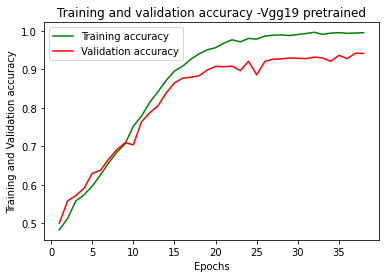

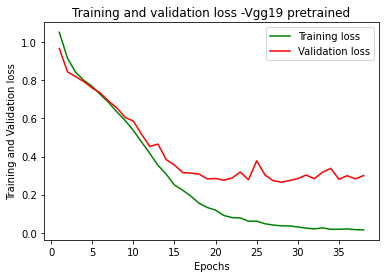

In [19]:
acc = r .history['accuracy']
epochs = range(1, len(acc)+1)
val_acc = r .history['val_accuracy']
loss = r .history['loss']
val_loss = r .history['val_loss']

#plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy -Vgg19 pretrained')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation accuracy')
plt.legend()
plt.figure()

#plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss -Vgg19 pretrained')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation loss')
plt.legend()
plt.show()

In [20]:
Vgg19PretrainPrediction = model_n.predict_generator(test_set) #making the class predictions on test data
Vgg19PretrainPrediction = np.argmax(Vgg19PretrainPrediction,axis=1)
accuracyBaseNet = accuracy_score(test_set.classes,Vgg19PretrainPrediction) #Calculating the classification accuracy of the model
print(f'Vgg19 pretrained model test accuracy is: {(accuracyBaseNet*100):.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Vgg19 pretrained model test accuracy is: 92.03%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


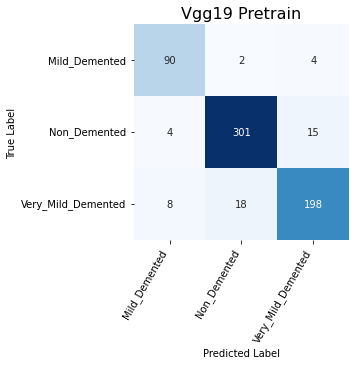

In [21]:
batch_size=16;
test_samples=640;
class_Names = test_set.class_indices
Y_pred_Vgg19Pretrain = model_n.predict_generator(test_set, test_samples // batch_size+1)
y_pred_Vgg19Pretrain= np.argmax(Y_pred_Vgg19Pretrain, axis=1)
class_Names = {v: k for k, v in class_Names.items()}
# collecting the class names
class_names_CNN = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented']

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap( cm,annot=True, square=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
tClasses = test_set.classes;
plot_heatmap(tClasses, y_pred_Vgg19Pretrain, class_names_CNN, ax1, title="Vgg19 Pretrain")    
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [22]:
#class_labels_vgg19Pretrain = test_set.class_indices
#class_labels_baseNet = {v: k for k, v in class_labels_vgg19Pretrain.items()}
target_names = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented']
print('\n Classification report: Pretrained VGG19 \n')
print(classification_report(test_set.classes, y_pred_Vgg19Pretrain, target_names=target_names))


 Classification report: Pretrained VGG19 

                    precision    recall  f1-score   support

     Mild_Demented       0.88      0.94      0.91        96
      Non_Demented       0.94      0.94      0.94       320
Very_Mild_Demented       0.91      0.88      0.90       224

          accuracy                           0.92       640
         macro avg       0.91      0.92      0.92       640
      weighted avg       0.92      0.92      0.92       640



#**Vgg19 as Feature Extractor**

In [34]:
vgg19FE = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg19FE.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
dataNorm = ImageDataGenerator(rescale=1./255)
def features_extractor(dir, sample):
    lbl = np.zeros(shape=(sample, 3)) #sample and class number
    ext_features = np.zeros(shape=(sample, 7, 7, 512)) #should match with output of last laayer of VGG19
    generator = dataNorm.flow_from_directory(
        dir, 
        target_size=(IMAGEX, IMAGEY), 
        batch_size=batch_size, 
        class_mode='categorical')
    i=0
    for input, labels in generator:
        features_batch = vgg19FE.predict(input) #extract features for each images using vgg19
        ext_features[i * batch_size : (i + 1) * batch_size] = features_batch 
        lbl[i * batch_size : (i + 1) * batch_size] = labels
        i += 1
        if i * batch_size >= sample:
            break
    return ext_features, lbl

In [36]:
#extract feature from train and test data using pretrained vgg19 model
train_features, train_labels = features_extractor(train_path, 4480)  
valid_features, valid_labels = features_extractor(valid_path, 1280)
test_features, test_labels = features_extractor(test_path, 640)

Found 4480 images belonging to 3 classes.
Found 1280 images belonging to 3 classes.
Found 640 images belonging to 3 classes.


In [38]:
#this Custom CNN model will predict the output based on the feature extracted by the VGG19 pretrain model
modelVGG19FE = Sequential()
# Padding = 'same'  results in padding the input such that the output has the same length as the original input
modelVGG19FE.add(Conv2D(32, (5, 5), padding='same',input_shape= (7, 7, 512))) #filter size 5x5 and num of filters 32
modelVGG19FE.add(Activation('relu'))
modelVGG19FE.add(MaxPooling2D(pool_size=(3,3))) #add maxpooling layer of size 3x3 to reduce the feature map size

modelVGG19FE.add(Conv2D(64,(5,5), padding='same'))
modelVGG19FE.add(Activation('relu'))
modelVGG19FE.add(MaxPooling2D(pool_size=(2,2)))

modelVGG19FE.add(Flatten())
modelVGG19FE.add(Dense(512, activation='relu'))
modelVGG19FE.add(Dense(64, activation='relu'))
modelVGG19FE.add(Dropout(0.25))
modelVGG19FE.add(Dense(3)) #define output layer which has same number of node as number of classes 
modelVGG19FE.add(Activation('softmax')) #softmax activation function to generate output

modelVGG19FE.summary(); #print the model summary

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          409632    
                                                                 
 activation_6 (Activation)   (None, 7, 7, 32)          0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          51264     
                                                                 
 activation_7 (Activation)   (None, 2, 2, 64)          0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                  

In [39]:
checkpoint = ModelCheckpoint("/content/modelPretrain/jaber_modelVGG19FE.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True) #early stopping if validation loss does not improve after a certain patience 

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001) #adjusting the learning rate 

callbacks = [earlystop, checkpoint, reduce_lr] # kepping the call backs into a callback list

In [40]:
modelVGG19FE.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.001,  decay=0.01),
  #optimizer=Adam(decay=0.01),
  #optimizer='adam',
  metrics=['accuracy']
)

In [41]:
VGG19FE = modelVGG19FE.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=16, 
                    callbacks=callbacks,
                    validation_data=(valid_features, valid_labels))
modelVGG19FE.save('/content/readymodel/modelVGG19FE.h5')

Epoch 1/40
275/280 [============================>.] - ETA: 0s - loss: 0.9499 - accuracy: 0.5034
Epoch 1: val_loss improved from inf to 0.85523, saving model to /content/modelPretrain/jaber_modelVGG19FE.h5
280/280 [==============================] - 2s 6ms/step - loss: 0.9495 - accuracy: 0.5045 - val_loss: 0.8552 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 2/40
271/280 [============================>.] - ETA: 0s - loss: 0.8434 - accuracy: 0.5650
Epoch 2: val_loss improved from 0.85523 to 0.80782, saving model to /content/modelPretrain/jaber_modelVGG19FE.h5
280/280 [==============================] - 1s 4ms/step - loss: 0.8419 - accuracy: 0.5645 - val_loss: 0.8078 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 3/40
268/280 [===========================>..] - ETA: 0s - loss: 0.7911 - accuracy: 0.5975
Epoch 3: val_loss improved from 0.80782 to 0.76133, saving model to /content/modelPretrain/jaber_modelVGG19FE.h5
280/280 [==============================] - 1s 4ms/step - loss: 0.7932 - accuracy: 0.5962 

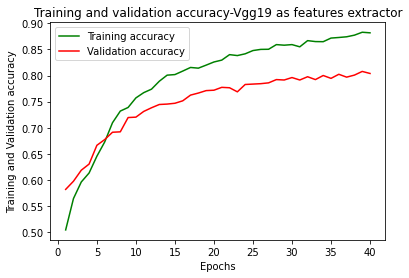

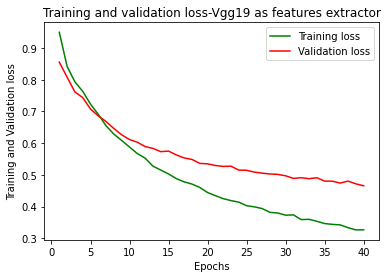

In [42]:
acc = VGG19FE.history['accuracy']
epochs = range(1, len(acc)+1)
val_acc = VGG19FE.history['val_accuracy']
loss = VGG19FE.history['loss']
val_loss = VGG19FE.history['val_loss']

#plot the train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy-Vgg19 as features extractor')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation accuracy')
plt.legend()
plt.figure()

#plot the train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss-Vgg19 as features extractor')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation loss')
plt.legend()
plt.show()

In [43]:
Vgg19FEPrediction = modelVGG19FE.predict(test_features) 
Vgg19FEPrediction = np.argmax(Vgg19FEPrediction,axis=1)
accuracyFEPrediction = accuracy_score(test_labels.argmax(1),Vgg19FEPrediction) #Calculating the classification accuracy of the model
print(f'Pre-trained Vgg as Feature extractor with DNN  model test accuracy is: {(accuracyFEPrediction*100):.2f}%')

Pre-trained Vgg as Feature extractor with DNN  model test accuracy is: 80.16%


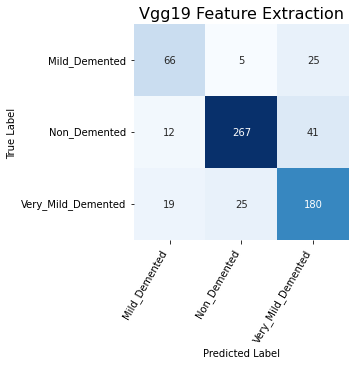

In [44]:
#class_Names = validation_generator.class_indices
#class_Names = {v: k for k, v in class_Names.items()}
# Get the names of the ten classes
class_names_CNN = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented']

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap( cm,annot=True, square=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
vggFE_preds=modelVGG19FE.predict(test_features) 
vgg_pred_class=np.argmax(vggFE_preds,axis=1)
vgg_true_class = test_labels.argmax(1)
plot_heatmap(vgg_true_class, vgg_pred_class, class_names_CNN, ax1, title="Vgg19 Feature Extraction")    
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [45]:
vggFE_preds=modelVGG19FE.predict(test_features) 
vggFE_preds=np.argmax(vggFE_preds,axis=1)
con_mat = tf.math.confusion_matrix(test_labels.argmax(1), vggFE_preds)
con_mat = np.array(con_mat)
#classification report for VGG19 network when used as feature extractor
vggFE_preds=modelVGG19FE.predict(test_features) 
vgg_pred_class=np.argmax(vggFE_preds,axis=1)
vgg_true_class = test_labels.argmax(1)
print('\nClassification report for VGG19 as a feature extractor\n')
classes_out = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented']
print(classification_report(vgg_true_class, vgg_pred_class , target_names=classes_out))


Classification report for VGG19 as a feature extractor

                    precision    recall  f1-score   support

     Mild_Demented       0.68      0.69      0.68        96
      Non_Demented       0.90      0.83      0.87       320
Very_Mild_Demented       0.73      0.80      0.77       224

          accuracy                           0.80       640
         macro avg       0.77      0.78      0.77       640
      weighted avg       0.81      0.80      0.80       640



#**Pretrained Resnet50**

In [10]:
#resizeing image for Resnet50
IMAGE_SIZE = [224, 224];
train_path = '/content/train'
valid_path = '/content/val'
test_path = '/content/test'

In [11]:
# add preprocessing layer to the front of VGG
ResNet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
ResNet.summary()

94781440/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [12]:
# don't train existing weights
for layer in ResNet.layers[:-3]:
  layer.trainable = False
# show trainable state of layers
ResNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [13]:
x = Flatten()(ResNet.output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
prediction = Dense(len(folders), activation='softmax')(x)
model_ResNet = Model(inputs=ResNet.input, outputs=prediction)
model_ResNet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
for layer in model_ResNet.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe2f8157250> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe2ef2f7850> False
<keras.layers.convolutional.Conv2D object at 0x7fe2ef6ff850> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe2ef2c6690> False
<keras.layers.core.activation.Activation object at 0x7fe2ed618c50> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe2ecdcf090> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe2e018ef10> False
<keras.layers.convolutional.Conv2D object at 0x7fe2ef2c65d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe2e01a9510> False
<keras.layers.core.activation.Activation object at 0x7fe2e01ae050> False
<keras.layers.convolutional.Conv2D object at 0x7fe2e01b1b50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe2e01bd690> False
<keras.layers.core.activation.Activation object at 0x7fe2e01c75d0> False

In [15]:
checkpoint = ModelCheckpoint("/content/modelPretrain/jaber_PretrainResnet50.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 10,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [16]:
model_ResNet.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.001,  decay=0.01),
  #optimizer=Adam(decay=0.01),
  #optimizer='adam',
  metrics=['accuracy']
)

In [17]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

training_set = train_datagen.flow_from_directory('/content/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

validation_set= validation_datagen.flow_from_directory('/content/val',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)

test_set= test_datagen.flow_from_directory('/content/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 4480 images belonging to 3 classes.
Found 1280 images belonging to 3 classes.
Found 640 images belonging to 3 classes.


In [18]:
# fit the model
res = model_ResNet.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=40,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  callbacks = callbacks
)

model_ResNet.save('/content/readymodel/jaberResnet.h5')

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


280/280 [==============================] - ETA: 0s - loss: 2.5923 - accuracy: 0.5085
Epoch 1: val_loss improved from inf to 0.84541, saving model to /content/modelPretrain/jaber_PretrainResnet50.h5
280/280 [==============================] - 30s 59ms/step - loss: 2.5923 - accuracy: 0.5085 - val_loss: 0.8454 - val_accuracy: 0.5961 - lr: 0.0010
Epoch 2/40
279/280 [============================>.] - ETA: 0s - loss: 0.8045 - accuracy: 0.6017
Epoch 2: val_loss improved from 0.84541 to 0.73613, saving model to /content/modelPretrain/jaber_PretrainResnet50.h5
280/280 [==============================] - 15s 53ms/step - loss: 0.8037 - accuracy: 0.6018 - val_loss: 0.7361 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 3/40
279/280 [============================>.] - ETA: 0s - loss: 0.7025 - accuracy: 0.6546
Epoch 3: val_loss improved from 0.73613 to 0.70336, saving model to /content/modelPretrain/jaber_PretrainResnet50.h5
280/280 [==============================] - 15s 53ms/step - loss: 0.7019 - accuracy: 

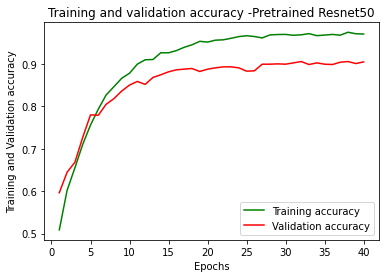

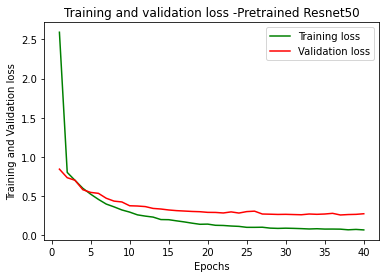

In [19]:
acc = res.history['accuracy']
epochs = range(1, len(acc)+1)
val_acc = res.history['val_accuracy']
loss = res.history['loss']
val_loss = res.history['val_loss']

#plot the train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy -Pretrained Resnet50')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation accuracy')
plt.legend()
plt.figure()

#plot the train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss -Pretrained Resnet50')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation loss')
plt.legend()
plt.show()

In [20]:
Resnet50PretrainPrediction = model_ResNet.predict_generator(test_set) #making the class predictions on test data
Resnet50PretrainPrediction = np.argmax(Resnet50PretrainPrediction,axis=1)
accuracyBaseNet = accuracy_score(test_set.classes,Resnet50PretrainPrediction) #Calculating the classification accuracy of the model
print(f'Resnet50 Pre-trained model test accuracy is: {(accuracyBaseNet*100):.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Resnet50 Pre-trained model test accuracy is: 89.22%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


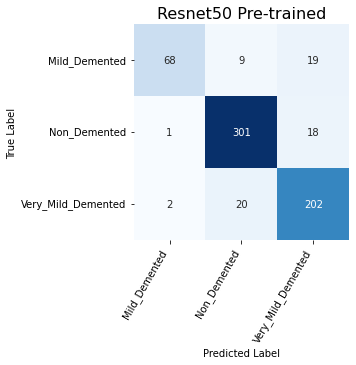

In [21]:
batch_size=16;
test_samples=640;
class_Names = test_set.class_indices
Y_pred_Resnet50pretrained = model_ResNet.predict_generator(test_set, test_samples // batch_size+1)
y_pred_Resnet50pretrained = np.argmax(Y_pred_Resnet50pretrained, axis=1)
class_Names = {v: k for k, v in class_Names.items()}
# collecting the class names
class_names_CNN = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented']

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap( cm,annot=True, square=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
tClasses = test_set.classes;
plot_heatmap(tClasses, y_pred_Resnet50pretrained, class_names_CNN, ax1, title="Resnet50 Pre-trained")    
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [22]:
#Classification Report
batch_size=16;
nb_test_samples=640;
Y_pred_ResNet = model_ResNet.predict_generator(test_set, nb_test_samples // batch_size+1)
y_pred_ResNet = np.argmax(Y_pred_ResNet, axis=1)
class_labels = test_set.class_indices
class_labels_ResNet = {v: k for k, v in class_labels.items()}
#target_names = list(class_labels_ResNet.values())
target_names = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented']
print('\n Classification report: Pretrained ResNet50 \n')
print(classification_report(test_set.classes, y_pred_ResNet, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.



 Classification report: Pretrained ResNet50 

                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.71      0.81        96
      Non_Demented       0.91      0.94      0.93       320
Very_Mild_Demented       0.85      0.90      0.87       224

          accuracy                           0.89       640
         macro avg       0.91      0.85      0.87       640
      weighted avg       0.90      0.89      0.89       640



#**Resnet50 as Feature Extractor**

In [24]:
resnet50FE = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
resnet50FE.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [25]:
dataNorm = ImageDataGenerator(preprocessing_function=preprocess_input)
def features_extractor(dir, sample):
    lbl = np.zeros(shape=(sample, 3)) #sample and class number
    ext_features = np.zeros(shape=(sample, 7, 7, 2048)) #should match with output of last laayer of resnet50
    generator = dataNorm.flow_from_directory(
        dir, 
        target_size=(IMAGEX, IMAGEY), 
        batch_size=batch_size, 
        class_mode='categorical')
    flag=0
    for input, labels in generator:
        features_batch = resnet50FE.predict(input) #extract features for each images using resnet50
        ext_features[flag * batch_size : (flag + 1) * batch_size] = features_batch 
        lbl[flag * batch_size : (flag + 1) * batch_size] = labels
        flag += 1
        if flag * batch_size >= sample:
            break;
    return ext_features, lbl

In [26]:
train_features_resnet50FE, train_labels_resnet50FE = features_extractor(train_path, 4480)  
val_features_resnet50FE, val_labels_resnet50FE = features_extractor(valid_path, 1280)
test_features_resnet50FE, test_labels_resnet50FE = features_extractor(test_path, 640)

Found 4480 images belonging to 3 classes.
Found 1280 images belonging to 3 classes.
Found 640 images belonging to 3 classes.


In [27]:
#define the Custom CNN model
modelresnet50FE = Sequential()

# Padding = 'same'  results in padding the input such that the output has the same length as the original input
modelresnet50FE.add(Conv2D(32, (5, 5), padding='same',input_shape= (7, 7, 2048))) #filter size 5x5 and num of filters 32
modelresnet50FE.add(Activation('relu'))
modelresnet50FE.add(Conv2D(64,(5,5), padding='same'))
modelresnet50FE.add(Activation('relu'))
modelresnet50FE.add(MaxPooling2D(pool_size=(2,2))) #add maxpooling layer of size 3x3 to reduce the feature map size

modelresnet50FE.add(Conv2D(64,(5,5), padding='same'))
modelresnet50FE.add(Activation('relu'))
modelresnet50FE.add(Conv2D(64,(5,5), padding='same'))
modelresnet50FE.add(Activation('relu'))
modelresnet50FE.add(MaxPooling2D(pool_size=(2,2)))

modelresnet50FE.add(Flatten())
modelresnet50FE.add(Dense(128, activation='relu'))
modelresnet50FE.add(Dense(64, activation='relu'))
modelresnet50FE.add(Dropout(0.25))
modelresnet50FE.add(Dense(3)) #define output layer which has same number of node as number of classes 
modelresnet50FE.add(Activation('softmax')) #softmax activation function to generate output

modelresnet50FE.summary() #print the model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 32)          1638432   
                                                                 
 activation (Activation)     (None, 7, 7, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 activation_1 (Activation)   (None, 7, 7, 64)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          102464    
                                                        

In [28]:
checkpoint = ModelCheckpoint("/content/modelPretrain/jaber_modelresnet50FE.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True) #early stopping if validation loss does not improve after a certain patience 

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 10,
                              verbose = 1,
                              min_delta = 0.0001) #adjusting the learning rate 


callbacks = [earlystop, checkpoint, reduce_lr] # kepping the call backs into a callback list

In [29]:
modelresnet50FE.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.001,  decay=0.01),
  #optimizer=Adam(decay=0.01),
  #optimizer='adam',
  metrics=['accuracy']
)

In [30]:
resnet50FE = modelresnet50FE.fit(train_features_resnet50FE, train_labels_resnet50FE,
                    epochs=40,
                    batch_size=16, 
                    callbacks=callbacks,
                    validation_data=(val_features_resnet50FE, val_labels_resnet50FE))
modelresnet50FE.save('/content/readymodel/resnet50FE.h5')

Epoch 1/40
279/280 [============================>.] - ETA: 0s - loss: 0.9196 - accuracy: 0.5293
Epoch 1: val_loss improved from inf to 0.85419, saving model to /content/modelPretrain/jaber_modelresnet50FE.h5
280/280 [==============================] - 4s 10ms/step - loss: 0.9194 - accuracy: 0.5295 - val_loss: 0.8542 - val_accuracy: 0.5945 - lr: 0.0010
Epoch 2/40
276/280 [============================>.] - ETA: 0s - loss: 0.7720 - accuracy: 0.6180
Epoch 2: val_loss improved from 0.85419 to 0.70203, saving model to /content/modelPretrain/jaber_modelresnet50FE.h5
280/280 [==============================] - 3s 10ms/step - loss: 0.7717 - accuracy: 0.6183 - val_loss: 0.7020 - val_accuracy: 0.6555 - lr: 0.0010
Epoch 3/40
279/280 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.7166
Epoch 3: val_loss improved from 0.70203 to 0.63094, saving model to /content/modelPretrain/jaber_modelresnet50FE.h5
280/280 [==============================] - 3s 10ms/step - loss: 0.6427 - accur

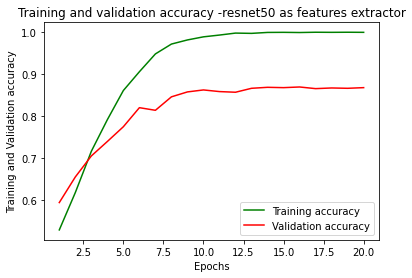

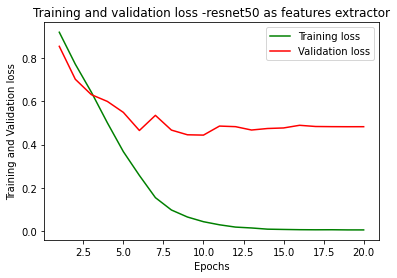

In [31]:
acc = resnet50FE.history['accuracy']
epochs = range(1, len(acc)+1)
val_acc = resnet50FE.history['val_accuracy']
loss = resnet50FE.history['loss']
val_loss = resnet50FE.history['val_loss']

#plot the train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy -resnet50 as features extractor')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation accuracy')
plt.legend()
plt.figure()

#plot the train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss -resnet50 as features extractor')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation loss')
plt.legend()

plt.show()

In [32]:
Resnet50FEPrediction = modelresnet50FE.predict(test_features_resnet50FE) 
Resnet50FEPrediction = np.argmax(Resnet50FEPrediction,axis=1)
accuracyFEPrediction = accuracy_score(test_labels_resnet50FE.argmax(1),Resnet50FEPrediction) #Calculating the classification accuracy of the model
print(f'Pre-trained Vgg as Feature extractor with DNN  model test accuracy is: {(accuracyFEPrediction*100):.2f}%')

Pre-trained Vgg as Feature extractor with DNN  model test accuracy is: 84.22%


In [33]:
resnet50FE_preds=modelresnet50FE.predict(test_features_resnet50FE) 
resnet50FE_preds=np.argmax(resnet50FE_preds,axis=1)
mat = tf.math.confusion_matrix(test_labels_resnet50FE.argmax(1), resnet50FE_preds)
mat = np.array(mat)
#classification report for resnet50 network when used as feature extractor

resnet50FE_preds=modelresnet50FE.predict(test_features_resnet50FE) 
resnet50FE_pred_class=np.argmax(resnet50FE_preds,axis=1)

resnet50FE_true_class = test_labels_resnet50FE.argmax(1)
print('\n Classification report for resnet50 as a feature extractor \n')
classes_out = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented']
print(classification_report(resnet50FE_true_class, resnet50FE_pred_class , target_names=classes_out))


 Classification report for resnet50 as a feature extractor 

                    precision    recall  f1-score   support

     Mild_Demented       0.75      0.73      0.74        96
      Non_Demented       0.89      0.92      0.90       320
Very_Mild_Demented       0.81      0.78      0.80       224

          accuracy                           0.84       640
         macro avg       0.82      0.81      0.81       640
      weighted avg       0.84      0.84      0.84       640



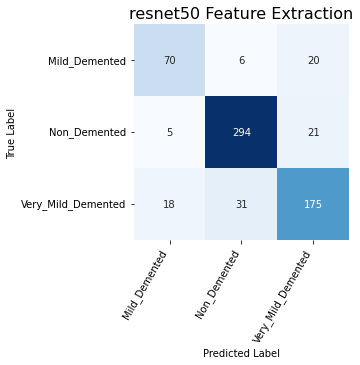

In [34]:
class_names_CNN = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented']
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap( cm,annot=True, square=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
resnet50_preds=modelresnet50FE.predict(test_features_resnet50FE) 
resnet50_pred_class=np.argmax(resnet50_preds,axis=1)
resnet50_true_class = test_labels_resnet50FE.argmax(1)

plot_heatmap(resnet50_true_class, resnet50_pred_class, class_names_CNN, ax1, title="resnet50 Feature Extraction")    
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
!nvidia-smi

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [ ]:
import cv2
image= cv2.imread('/content/test/Very_Mild_Demented/verymild_1024.jpg');
image_resize= cv2.resize(image, (224,224));
image= np.expand_dims(image_resize, axis=0);
print(image.shape);
train_ds= tf.keras.preprocessing.image_dataset_from_directory (train_path)

pred= model_aug.predict(image);
print(pred)
class_names= train_ds.class_names;
print(class_names);

output_class= class_names[np.argmax(pred)]
print("The predicted class is: " , output_class)